In [15]:
from extract_timings import extract_test_timings

def extract_timings(log_path: str):
    timings = extract_test_timings(log_path)

    startup_times = timings["startup_times"]
    generation_times = timings["generation_times"]
    wakeup_times = timings["wakeup_times"]
    sleep_times = timings["sleep_times"]
    
    print(f"Sleep times: {sleep_times}")
    print(f"Wakeup times: {wakeup_times}")
    
    return startup_times, generation_times, wakeup_times, sleep_times

In [11]:
def split_timings(startup_times, generation_times, wakeup_times, sleep_times):
    # Case A: No sleep
    # First 6 times are for Models A & B alternately
    startup_times_no_sleep = startup_times[:6]
    model_a_startup_no_sleep = startup_times_no_sleep[::2]
    model_b_startup_no_sleep = startup_times_no_sleep[1::2]

    # Generation times for no sleep
    generation_times_no_sleep = generation_times[:6]
    model_a_generation_no_sleep = generation_times_no_sleep[::2]
    model_b_generation_no_sleep = generation_times_no_sleep[1::2]


    # Case B: With sleep
    # Last 2 times are for Models A & B alternately
    startup_times_sleep = startup_times[6:]
    model_a_startup_sleep = startup_times_sleep[0]
    model_b_startup_sleep = startup_times_sleep[1]

    # Generation times for no sleep
    # There are 8 generation times
    generation_times_sleep = generation_times[6:]
    model_a_generation_sleep = generation_times_sleep[::2]
    model_b_generation_sleep = generation_times_sleep[1::2]

    # Sleep times, there are 8
    model_a_sleep_times = sleep_times[::2]
    model_b_sleep_times = sleep_times[1::2]

    # Wakeup time, there is only 6
    model_a_wakeup_times = wakeup_times[::2]
    model_b_wakeup_times = wakeup_times[1::2]
    
    return (model_a_startup_no_sleep, model_a_generation_no_sleep, model_a_startup_sleep,
            model_a_generation_sleep, model_a_sleep_times, model_a_wakeup_times,
            model_b_startup_no_sleep, model_b_generation_no_sleep, model_b_startup_sleep,
            model_b_generation_sleep, model_b_sleep_times, model_b_wakeup_times)

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def draw_boxplots(
    model_a_startup_no_sleep, model_a_generation_no_sleep, model_a_startup_sleep,
    model_a_generation_sleep, model_a_sleep_times, model_a_wakeup_times,
    model_b_startup_no_sleep, model_b_generation_no_sleep, model_b_startup_sleep,
    model_b_generation_sleep, model_b_sleep_times, model_b_wakeup_times
):

    # ---------- Case A: no sleep (your original) ----------
    no_sleep_labels = []
    no_sleep_values = []

    for a, g, b, gb in zip(model_a_startup_no_sleep,
                           model_a_generation_no_sleep,
                           model_b_startup_no_sleep,
                           model_b_generation_no_sleep):
        no_sleep_values.extend([a, g, b, gb])
        no_sleep_labels.extend(['Load A', 'Gen A', 'Load B', 'Gen B'])

    # ---------- Case B: with sleep ----------
    sleep_labels = []
    sleep_values = []

    # Build segments as:
    # Cycle 0:
    #   Load A → Gen A → Sleep A → Load B → Gen B → Sleep B
    # Cycles 1..:
    #   Wakeup A → Gen A → Sleep A → Wakeup B → Gen B → Sleep B

    for i, (ga, sa, gb, sb) in enumerate(
        zip(model_a_generation_sleep, model_a_sleep_times,
            model_b_generation_sleep, model_b_sleep_times)
    ):
        if i == 0:
            # First cycle includes the initial loads
            sleep_labels.extend(['Load A', 'Gen A', 'Sleep A',
                                 'Load B', 'Gen B', 'Sleep B'])
            sleep_values.extend([model_a_startup_sleep, ga, sa,
                                 model_b_startup_sleep, gb, sb])
        else:
            # Later cycles use wakeup times instead of additional loads
            sleep_labels.extend(['Wakeup A', 'Gen A', 'Sleep A',
                                 'Wakeup B', 'Gen B', 'Sleep B'])
            sleep_values.extend([model_a_wakeup_times[i-1], ga, sa,
                                 model_b_wakeup_times[i-1], gb, sb])

    # ---------- Colors for each type of segment ----------
    color_map = {
        'Load A':   'blue',
        'Gen A':    'orange',
        'Sleep A':  'cyan',
        'Wakeup A': 'black',

        'Load B':   'green',
        'Gen B':    'red',
        'Sleep B':  'yellow',
        'Wakeup B': 'limegreen',
    }

    no_sleep_colors = [color_map[l] for l in no_sleep_labels]
    sleep_colors    = [color_map[l] for l in sleep_labels]

    # ---------- Plot both horizontal stacked bars ----------
    fig, ax = plt.subplots(figsize=(12, 3))
    # y=1: Case A (no sleep)
    cumulative = 0
    for v, lab, c in zip(no_sleep_values, no_sleep_labels, no_sleep_colors):
        ax.barh(1, v, left=cumulative, color=c)
        cumulative += v
    total_no_sleep = cumulative

    # y=0: Case B (with sleep)
    cumulative = 0
    for v, lab, c in zip(sleep_values, sleep_labels, sleep_colors):
        ax.barh(0, v, left=cumulative, color=c)
        cumulative += v
    total_sleep = cumulative

    # ensure space for annotations and place them at the end of each bar
    max_total = max(total_no_sleep, total_sleep, 1e-6)
    ax.set_xlim(0, max_total * 1.15)
    offset = max_total * 0.01  # small offset to the right of the bar end

    ax.text(total_no_sleep + offset, 1, f"{total_no_sleep:.2f}s", va='center', fontsize=9)
    ax.text(total_sleep + offset, 0, f"{total_sleep:.2f}s", va='center', fontsize=9)

    ax.set_yticks([1, 0])
    ax.set_yticklabels(['No sleep', 'With sleep'])

    ax.set_xlabel('Time (seconds)')
    ax.set_title('Model Load / Generation with and without Sleep\nModel A: Llama3.2-3B & Model B: Qwen2.5-3B')

    # Legend using proxy artists
    legend_labels = ['Load A', 'Wakeup A', 'Gen A', 'Sleep A',
                     'Load B', 'Wakeup B', 'Gen B', 'Sleep B']
    legend_elements = [
        Patch(facecolor=color_map[lab], label=lab)
        for lab in legend_labels
    ]
    ax.legend(handles=legend_elements, ncol=2, loc='lower right')

    plt.tight_layout()
    plt.show()


Processing log: H100/test_lvl1.log
Sleep times: [3.681, 4.033, 0.245, 0.246, 0.246, 0.243, 0.244, 0.246]
Wakeup times: [0.303, 0.295, 0.293, 0.294, 0.295, 0.294]


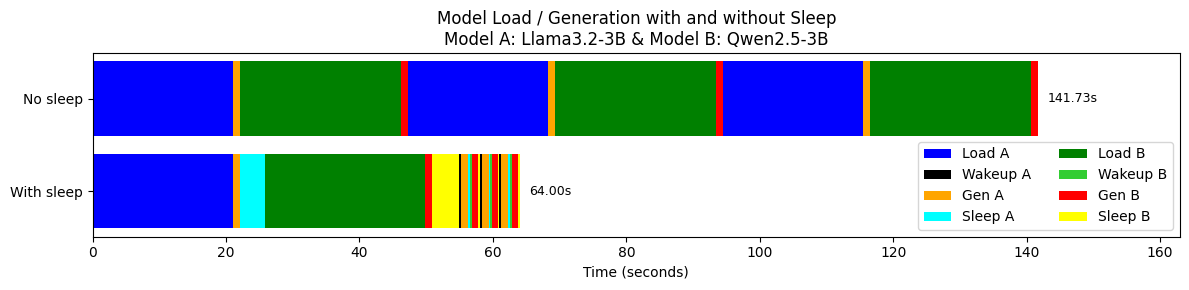

Processing log: H100/test_lvl2.log
Sleep times: [0.133, 0.129, 0.137, 0.133, 0.137, 0.131, 0.136, 0.133]
Wakeup times: [1.051, 1.03, 1.054, 1.028, 1.056, 1.032]


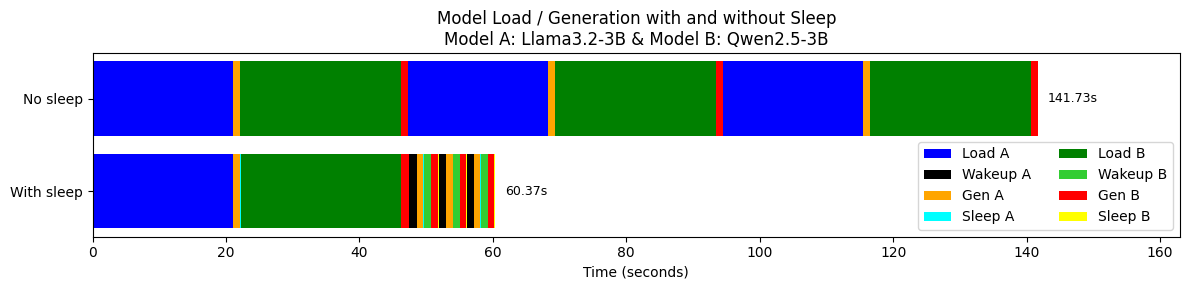

Processing log: L40S/test_lvl1.log
Sleep times: [3.829, 4.183, 0.411, 0.423, 0.411, 0.42, 0.413, 0.421]
Wakeup times: [0.824, 0.856, 0.822, 0.833, 0.83, 0.827]


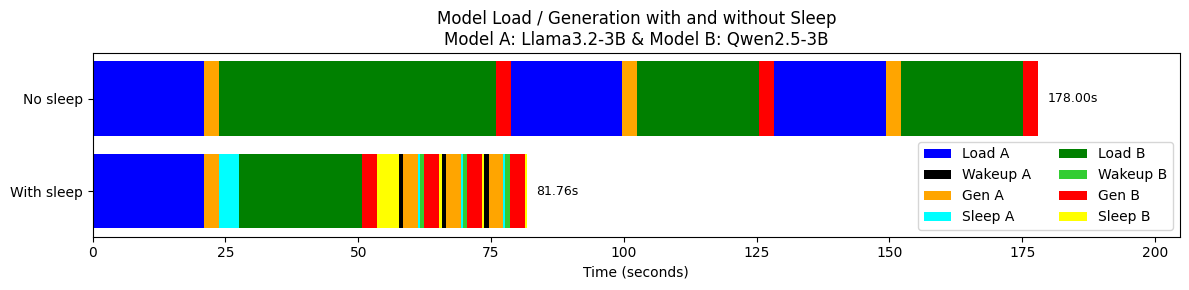

Processing log: L40S/test_lvl2.log
Sleep times: [0.29, 0.299, 0.28, 0.287, 0.281, 0.289, 0.28, 0.288]
Wakeup times: [1.462, 1.488, 1.471, 1.471, 1.475, 1.468]


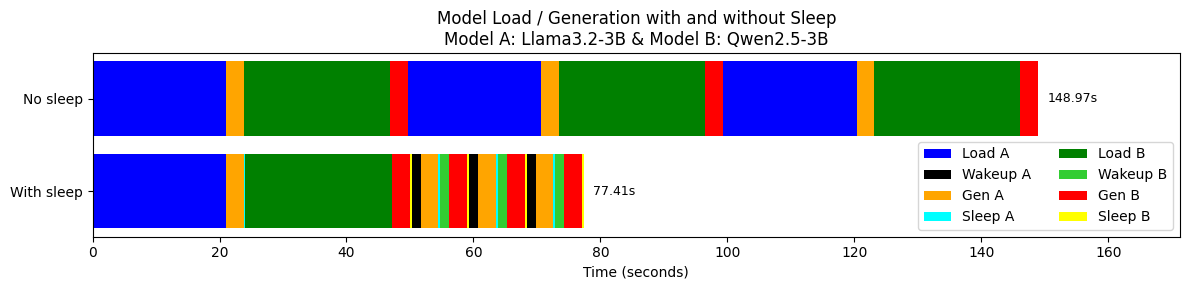

In [23]:
logs = ["H100/test_lvl1.log", "H100/test_lvl2.log", "L40S/test_lvl1.log", "L40S/test_lvl2.log"]

for log in logs:
    print(f"Processing log: {log}")
    startup_times, generation_times, wakeup_times, sleep_times = extract_timings(f"logs/{log}")
    (model_a_startup_no_sleep, model_a_generation_no_sleep, model_a_startup_sleep,
    model_a_generation_sleep, model_a_sleep_times, model_a_wakeup_times,
    model_b_startup_no_sleep, model_b_generation_no_sleep, model_b_startup_sleep,
    model_b_generation_sleep, model_b_sleep_times, model_b_wakeup_times) = split_timings(
        startup_times, generation_times, wakeup_times, sleep_times
    )
    
    draw_boxplots(
        model_a_startup_no_sleep, model_a_generation_no_sleep, model_a_startup_sleep,
        model_a_generation_sleep, model_a_sleep_times, model_a_wakeup_times,
        model_b_startup_no_sleep, model_b_generation_no_sleep, model_b_startup_sleep,
        model_b_generation_sleep, model_b_sleep_times, model_b_wakeup_times
    )